# Example: Optimal adversaries for dense MNIST model

This notebook gives an example where OMLT is used to find adversarial examples for a trained dense neural network. We follow the below steps:<br>
1.) A neural network with ReLU activation functions is trained to classify images from the MNIST dataset <br>
2.) OMLT is used to generate a mixed-integer encoding of the trained model using the big-M formulation <br>
3.) The model is optimized to find the maximum classification error (defined by an "adversarial" label) over a small input region <br>


## Library Setup
This notebook assumes you have a working PyTorch environment to train the neural network for classification. The neural network is then formulated in Pyomo using OMLT which therefore requires working Pyomo and OMLT installations.

The required Python libraries used this notebook are as follows: <br>
- `numpy`: used for manipulate input data <br>
- `torch`: the machine learning language we use to train our neural network
- `torchvision`: a package containing the MNIST dataset
- `pyomo`: the algebraic modeling language for Python, it is used to define the optimization model passed to the solver
- `onnx`: used to express trained neural network models
- `omlt`: the package this notebook demonstates. OMLT can formulate machine learning models (such as neural networks) within Pyomo

**NOTE:** This notebook also assumes you have a working MIP solver executable (e.g., CBC, Gurobi) to solve optimization problems in Pyomo. The open-source solver CBC is called by default.

In [89]:
#Import requisite packages
#data manipulation
import numpy as np
import tempfile

#pytorch for training neural network
import torch, torch.onnx
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
from omlt.neuralnet import FullSpaceNNFormulation
from omlt.io.onnx import write_onnx_model_with_bounds, load_onnx_neural_network_with_bounds

In [90]:
train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 1000}

#build DataLoaders for training and test sets
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
dataset2 = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

## Import the Data and Train a Neural Network

We begin by loading the MNIST dataset as `DataLoader` objects with pre-set training and testing batch sizes:


In [91]:
from torch import nn
hidden_size = 50

class NoSoftmaxNet(nn.Module):
    #define layers of neural network
    def __init__(self):
        super().__init__()
        self.hidden1  = nn.Linear(784, hidden_size)
        self.hidden2  = nn.Linear(hidden_size, hidden_size)
        self.output  = nn.Linear(hidden_size, 10)
        self.relu = nn.ReLU()

    #define forward pass of neural network
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

#create neural network without LogSoftmax and load parameters from existing model
model = NoSoftmaxNet()

In [92]:
import torch

# Path to the saved model
model_path = "classification_model.pth"

# Load the model
model = NoSoftmaxNet()
model.load_state_dict(torch.load(model_path))

print("Model loaded successfully.")

Model loaded successfully.


## Build a MIP Formulation for the Trained Neural Network

We are now ready to use OMLT to formulate the trained model within a Pyomo optimization model. We use a  binary variable representation to represent the ReLU activation logic which is created automatically using the `FullSpaceNNFormulation` object (one could also simply use the `ReluBigFormulation` object).

First, we define a neural network without the final `LogSoftmax` activation. Although this activation helps greatly in training the neural network model, it is not trivial to encode in the optimization model. The ranking of the output labels remains the same without the activation, so it can be omitted when finding optimal adversaries. 

Next, we define an instance of the optimal adversary problem. We formulate the optimization problem as: <br>

$
\begin{align*} 
& \max_x \ y_k - y_j \\
& s.t. y_k = N_k(x) \\ 
&\quad |x - \bar{x}|_\infty \leq 0.05
\end{align*}
$

where $\bar{x}$ corresponds to an image in the test dataset with true label `j`, and $N_k(x)$ is the value of the neural network output corresponding to adversarial label `k` given input `x`. PyTorch needs to trace the model execution to export it to ONNX, so we also define a dummy input tensor `x_temp`.

In [93]:
train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 1000}

#build DataLoaders for training and test sets
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
dataset2 = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [94]:
#load image and true label from test set with index 'problem_index'
problem_index = 0
image = dataset2[problem_index][0].view(-1,28*28).detach().numpy()
label = dataset2[problem_index][1]

#define input region defined by infinity norm
epsilon_infty = 0.1
lb = np.maximum(0, image - epsilon_infty)
ub = np.minimum(1, image + epsilon_infty)

#save input bounds as dictionary
input_bounds = {}
for i in range(28*28):
    input_bounds[i] = (float(lb[0][i]), float(ub[0][i])) 
    
#define dummy input tensor    
x_temp = dataset2[problem_index][0].view(-1,28*28)

We can now export the PyTorch model as an ONNX model and use `load_onnx_neural_network_with_bounds` to load it into OMLT.

In [95]:
with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    #export neural network to ONNX
    torch.onnx.export(
        model,
        x_temp,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    #write ONNX model and its bounds using OMLT
    write_onnx_model_with_bounds(f.name, None, input_bounds)
    #load the network definition from the ONNX model
    network_definition = load_onnx_neural_network_with_bounds(f.name)

As a sanity check before creating the optimization model, we can print the properties of the neural network layers from `network_definition`. This allows us to check input/output sizes, as well as activation functions.

In [96]:
for layer_id, layer in enumerate(network_definition.layers):
    print(f"{layer_id}\t{layer}\t{layer.activation}")

0	InputLayer(input_size=[784], output_size=[784])	linear
1	DenseLayer(input_size=[784], output_size=[50])	relu
2	DenseLayer(input_size=[50], output_size=[50])	relu
3	DenseLayer(input_size=[50], output_size=[10])	linear


Finally, we can load `network_definition` as a full-space `FullSpaceNNFormulation` object.

In [97]:
formulation = FullSpaceNNFormulation(network_definition)

## Solve Optimal Adversary Problem in Pyomo

We now encode the trained neural network in a Pyomo model from the `FullSpaceNNFormulation` object. 

In [98]:
#create pyomo model
m = pyo.ConcreteModel()

#create an OMLT block for the neural network and build its formulation
m.nn = OmltBlock()
m.nn.build_formulation(formulation) 

WARNING (W1002): Setting Var 'nn.scaled_inputs[202]' to a numeric value `0`
outside the bounds (0.229411780834198, 0.42941176891326904).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[203]' to a numeric value `0`
outside the bounds (0.6254901885986328, 0.8254902362823486).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[204]' to a numeric value `0`
outside the bounds (0.5235294103622437, 0.7235294580459595).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[205]' to a numeric value `0`
outside the bounds (0.49215689301490784, 0.6921569108963013).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[206]' to a numeric value `0`
outside the bounds (0.135294109582901, 0.33529412746429443).
    See also https://pyomo.readthe

WARNING (W1002): Setting Var 'nn.scaled_inputs[410]' to a numeric value `0`
outside the bounds (0.8960784077644348, 1.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[411]' to a numeric value `0`
outside the bounds (0.14313724637031555, 0.343137264251709).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[436]' to a numeric value `0`
outside the bounds (0.4215686619281769, 0.6215686798095703).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[437]' to a numeric value `0`
outside the bounds (0.8960784077644348, 1.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[438]' to a numeric value `0`
outside the bounds (0.6333333253860474, 0.8333333730697632).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w

### initialize the input and output variables

In [99]:
l1_norm_ball = False
l2_norm_ball = False

input_size = 28*28

# Variable representing the auxiliary variable for L1 norm
if ( not l1_norm_ball and not l2_norm_ball):
    m.auxiliary = pyo.Var(domain=pyo.NonNegativeReals)

if l1_norm_ball:
    # make the range of the auxiliary variable to be the same as the input
    m.auxiliary = pyo.Var(range(0, input_size), domain=pyo.NonNegativeReals)

In [100]:
m.input = pyo.Var(range(28*28), domain=pyo.NonNegativeReals)  # Assuming inputs should be non-negative
m.output = pyo.Var(range(10), domain=pyo.Reals)

In [101]:
m.connect_inputs = pyo.ConstraintList()
m.connect_outputs = pyo.ConstraintList()

for i in range(28*28):  # For input connections
    m.connect_inputs.add(m.input[i] == m.nn.inputs[i])
for j in range(10):  # For output connections
    m.connect_outputs.add(m.output[j] == m.nn.outputs[j])

### property violation

In [102]:
# booleans to know what is the adversary

digit0_adversary = False
digit1_adversary = False
digit2_adversary = False
digit3_adversary = True
digit4_adversary = False
digit5_adversary = False
digit6_adversary = False
digit7_adversary = False
digit8_adversary = False
digit9_adversary = False

digits_adversary = [digit0_adversary, digit1_adversary, digit2_adversary, digit3_adversary, digit4_adversary, digit5_adversary, digit6_adversary, digit7_adversary, digit8_adversary, digit9_adversary]

# assert only one digit hot
assert sum(digits_adversary) == 1, "Only one digit can be the adversary"

# assert not the true label is the adversary 
assert not digits_adversary[label], "The true label cannot be the adversary"

In [103]:
# construt the property of the output f(x)
# f(x) = - (output[label] - output[adversary])
# we need f(x) + margin <= 0

margin = 1e-3 # margin to convert strict inequality to non-strict

hot_digit = digits_adversary.index(True)
m.output_property = pyo.Constraint(expr = m.output[label] - m.output[hot_digit] + margin <= 0)

### construct the objective function

In [104]:
center = image[0]
input_neurons = 28*28
assert len(center) == input_neurons, "Center should have the same size as the input"

if l1_norm_ball:
    # constraint list
    m.l1_constraints = pyo.ConstraintList()
    # add that each difference must be less than auxiliary
    # and greater than negative auxiliary
    for i in range(input_neurons):
        m.l1_constraints.add(m.input[i] - center[i] <= m.auxiliary[i])
        m.l1_constraints.add(-m.auxiliary[i] <= m.input[i] - center[i])


elif l1_norm_ball == False and l2_norm_ball == False:
    # constraint list
    m.l1_constraints = pyo.ConstraintList()
    # add that each difference must be less than auxiliary
    # and greater than negative auxiliary
    for i in range(input_neurons):
        m.l1_constraints.add(m.input[i] - center[i] <= m.auxiliary)
        m.l1_constraints.add(- m.auxiliary <= m.input[i] - center[i])

In [105]:
if l1_norm_ball:
    m.obj = pyo.Objective(expr=sum(m.auxiliary[i] for i in range(input_neurons)), sense = pyo.minimize)
elif l2_norm_ball:
    m.obj = pyo.Objective(expr=sum((m.input[i] - center[i]) ** 2 for i in range(input_neurons)), sense=pyo.minimize)
else:
   m.obj = pyo.Objective(expr=m.auxiliary, sense=pyo.minimize)

### solve the problem

In [106]:
# solve the model

pyo.SolverFactory('cbc').solve(m, tee=True)


Welcome to the CBC MILP Solver 
Version: 2.9.7 
Build Date: Oct 10 2015 
Revision Number: 2226 

command line - C:\CBC\win32-msvc12\bin\cbc.exe -printingOptions all -import C:\Users\HP\AppData\Local\Temp\tmpevez4_gx.pyomo.lp -stat=1 -solve -solu C:\Users\HP\AppData\Local\Temp\tmpevez4_gx.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 1283 (-3188) rows, 1070 (-2417) columns and 42637 (-8395) elements
Statistics for presolved model
Original problem has 100 integers (100 of which binary)
Presolved problem has 89 integers (89 of which binary)
==== 1069 zero objective 2 different
1069 variables have objective of 0
1 variables have objective of 1
==== absolute objective values 2 different
1069 variables have objective of 0
1 variables have objective of 1
==== for integers 89 zero objective 1 different
89 variables have objective of 0
==== for integers absolute objective values 1 different
89 variables have objective of 0
===== end objective cou

{'Problem': [{'Name': 'unknown', 'Lower bound': 0.06932808, 'Upper bound': 0.06932808, 'Number of objectives': 1, 'Number of constraints': 1283, 'Number of variables': 1070, 'Number of binary variables': 100, 'Number of integer variables': 100, 'Number of nonzeros': 1, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 2385.37, 'Wallclock time': 2385.37, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 14999, 'Number of created subproblems': 14999}, 'Black box': {'Number of iterations': 1585486}}, 'Error rc': 0, 'Time': 2386.2327342033386}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [108]:
# print the output and objective

for i in range(10):
    print(f"Output {i}: {m.output[i].value}", end=" ")
    print(f"difference: {m.output[label].value - m.output[i].value}")
print("Objective: ", m.obj())

Output 0: -7.3852862 difference: 9.4770513
Output 1: -8.3719503 difference: 10.4637154
Output 2: -2.3713469 difference: 4.463112
Output 3: 2.0927651 difference: -0.0009999999999998899
Output 4: -15.941416 difference: 18.0331811
Output 5: -5.4373343 difference: 7.5290994
Output 6: -18.606449 difference: 20.6982141
Output 7: 2.0917651 difference: 0.0
Output 8: -6.4599878 difference: 8.5517529
Output 9: -4.7166272 difference: 6.8083922999999995
Objective:  0.069328082


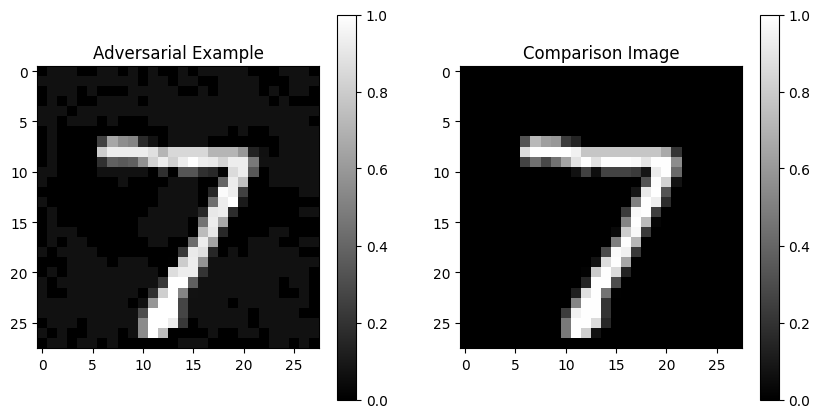

In [112]:
import torch
import matplotlib.pyplot as plt

# Create a torch tensor for the adversarial input, assuming it's flattened
input = torch.zeros(28*28)

# Assuming m.input contains the perturbed image values from a Pyomo model
for i in range(28*28):
    input[i] = m.input[i].value

# Reshape the adversarial example to a 28x28 array for visualization
image_data = input.reshape(28,28).numpy()  # Convert to numpy array if not already

# Assuming 'image' is another 28x28 array you want to plot for comparison
# Ensure 'image' is also a numpy array and correctly shaped
image = image.reshape(28,28)

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the adversarial example
axes[0].imshow(image_data, cmap='gray')
axes[0].set_title('Adversarial Example')
axes[0].colorbar()  # Optionally add a colorbar to see the intensity scale

# Plot the original or comparison image
axes[1].imshow(image, cmap='gray')
axes[1].set_title('Comparison Image')
axes[1].colorbar()  # Optionally add a colorbar to see the intensity scale

plt.show()


In [119]:
import numpy as np

# Assuming 'image' and 'input' are numpy arrays and have been reshaped if necessary
# Reshape them to 28x28 if they are flattened, or make sure they are in the same shape
image_reshaped = image.reshape(28,28)
input_reshaped = np.array(input.reshape(28,28))

# Compute the difference
difference = image_reshaped - input_reshaped

# Find the infinity norm of the difference
infinity_norm = np.linalg.norm(difference.flatten(), np.inf)

print("Infinity norm of the difference:", infinity_norm)


Infinity norm of the difference: 0.0693281


In [122]:
# solve the model

pyo.SolverFactory('bonmin').solve(m, tee=True)


Bonmin 1.8.4 using Cbc 2.9.7 and Ipopt 3.12.4
bonmin: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 2.5239998e-008      473 42.006


In [121]:
# print the output and objective

for i in range(10):
    print(f"Output {i}: {m.output[i].value}", end=" ")
    print(f"difference: {m.output[label].value - m.output[i].value}")
print("Objective: ", m.obj())

Output 0: -22.835959494216688 difference: 12.088347728161681
Output 1: -17.295535004132724 difference: 6.547923238077717
Output 2: -14.493345659603746 difference: 3.7457338935487385
Output 3: -9.749243260528868 difference: -0.9983685055261393
Output 4: -18.70568930300551 difference: 7.958077536950503
Output 5: -11.521563830357733 difference: 0.7739520643027262
Output 6: -28.892246747514715 difference: 18.14463498145971
Output 7: -10.747611766055007 difference: 0.0
Output 8: -14.897248293964383 difference: 4.149636527909376
Output 9: -11.920488221255763 difference: 1.1728764552007558
Objective:  1.062074984809389e-05


Next, we define an adversarial label as the true label plus one (or zero if the true label is nine), as well as the objective function for optimization.

## Adversarial Attack Explanation

- **Label**: This is the true output of the network.
- **Adversary**: This is another output of the network, specifically the class label directly following the true label in a cyclic sequence.
- **Objective**: We aim to minimize the difference between the logits of the true class (`logit_true`) and the adversary class (`logit_adversary`). The expression for this is `logit_true - logit_adversary`.

### Why Minimize This Difference?

By minimizing the expression `logit_true - logit_adversary`, we effectively maximize the error expressed as `logit_adversary - logit_true`. This strategy aims to find the smallest perturbation to the input image that leads to the largest error in classification. In simpler terms, it seeks to identify the least change necessary to fool the classifier into making the most confident wrong prediction.

### Implications

- **Perturbation**: The optimization finds a perturbation of the input image that results in the maximum misclassification error.
- **Optimal Solution**: While other perturbations might also cause classification errors, the solution derived from this approach yields the largest error.
- **Confidence Misplaced**: The key result is that this particular perturbation causes the classifier to have the highest confidence in an incorrect classification. The classifier is not only wrong but is also highly sure of its incorrect decision.
